In [1]:
import wobble
import matplotlib.pyplot as plt
import numpy as np

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
o = [57, 58]
starname = '51peg'
data = wobble.Data(starname+'_e2ds.hdf5', filepath='data/', orders=o)

In [3]:
model = wobble.Model(data)
model.add_star(starname)
model.add_telluric('tellurics')
print(model)

Model consisting of the following components: 
51peg: RVs variable; 0 variable basis components
tellurics: RVs fixed; 0 variable basis components


Inject some noise & try to get back to the pipeline values by optimizing:

In [4]:
import tensorflow as tf
session = wobble.get_session()
session.run(tf.global_variables_initializer())
pipeline_rvs = session.run(model.components[0].rvs_block[0])
model.components[0].rvs_block[0].load(pipeline_rvs + np.random.normal(0., 100., data.N), session)

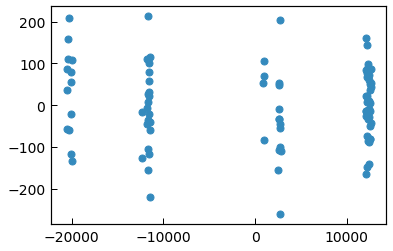

In [5]:
star_rvs = session.run(model.components[0].rvs_block[0])
initial_rvs = np.copy(star_rvs)
plt.scatter(pipeline_rvs, star_rvs - pipeline_rvs)

In [6]:
%%time
niter = 100
results = wobble.optimize_orders(model, data, niter=niter, save_history=True, basename=starname)

--- ORDER 0 ---


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


saving optimization history to 51peg_o0_history.hdf5
--- ORDER 1 ---


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


saving optimization history to 51peg_o1_history.hdf5
Results: writing to results.hdf5
CPU times: user 2min 11s, sys: 17.1 s, total: 2min 28s
Wall time: 1min 19s


In [7]:
history = wobble.History(model, data, 0, niter, filename=starname+'_o1_history.hdf5')

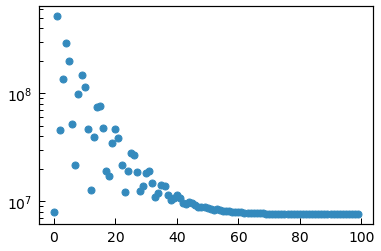

In [8]:
plt.scatter(np.arange(len(history.nll_history)), history.nll_history)
ax = plt.gca()
ax.set_yscale('log')

In [ ]:
star_ys = getattr(results, '{0}_ys_predicted'.format(starname))[0]
t_ys = results.tellurics_ys_predicted[0]
data_xs = results.xs[0]
data_ys = results.ys[0]
rvs_star = getattr(results, '{0}_rvs_block'.format(starname))[0]
resids = np.exp(data_ys) - np.exp(results.ys_predicted[0])

In [ ]:
epoch = 12
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]})
ax.plot(np.exp(data_xs[epoch]), np.exp(star_ys[epoch]), label='star model', lw=1.5)
ax.plot(np.exp(data_xs[epoch]), np.exp(t_ys[epoch]), label='tellurics model', lw=1.5)
ax.scatter(np.exp(data_xs[epoch]), np.exp(data_ys[epoch]), marker=".", alpha=0.4, c='k', label='data')
ax.set_xlim([5940, 5945])
ax.set_ylim([0.77, 1.03])
ax.set_xticklabels([])
ax.set_ylabel('Normalized Flux', fontsize=14)
ax2.scatter(np.exp(data_xs[epoch]), resids[epoch], marker=".", alpha=0.4, c='k')
ax2.set_xlim([5940, 5945])
ax2.set_ylim([-0.05, 0.05])
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel('Resids', fontsize=14)

# Shrink current axis by 50%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

In [ ]:
plt.plot(np.exp(data_xs[epoch]), np.exp(t_ys[epoch]))
plt.xlim([5940, 5945])
plt.ylim([0.8, 1.05])
plt.xlabel('Wavelength (A)')
plt.title('Telluric model, order 57 zoom');

In [ ]:
from harps_hacks import read_harps
from wobble.utils import fit_continuum
f = '/Users/mbedell/python/wobble/data/telluric/HARPS.2009-05-09T23:40:43.280_e2ds_A.fits'
wave,flux = read_harps.read_spec_2d(f)
snrs = read_harps.read_snr(f)

In [ ]:
wave2,flux2 = np.exp(data_xs[epoch]), np.exp(t_ys[epoch])
wave1,flux1 = wave[o[0]], flux[o[0]]
ivars1 = np.zeros_like(flux1) + snrs[o[0]]**2 # HACK
flux1 = np.exp(np.log(flux1) - fit_continuum(np.log(wave1), np.log(flux1), ivars1))

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(wave1,flux1+0.012,color='k',alpha=0.7,label='standard star')
ax.plot(wave2,flux2,color='r',alpha=0.7,lw=1.5,label='model')
#ax.set_xlim([min(wave2),max(wave2)])
ax.set_xlim([5940, 5945])
ax.set_ylabel('Normalized Flux', fontsize=18)
ax.legend(loc='upper right', fontsize=16)
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=18)
fig.tight_layout()

In [ ]:
plt.plot(np.exp(data_xs[epoch]), np.exp(star_ys[epoch]))
plt.xlim([5939, 5945])
plt.ylim([0.8, 1.05])
plt.xlabel('Wavelength (A)')
plt.title('Star model, order 57 zoom');

In [ ]:
template_xs[1001] - template_xs[1000]

In [ ]:
session.run(data.xs[0][0][3001] - data.xs[0][0][3000])


In [ ]:
star_rvs = session.run(model.components[0].rvs_block[0])
plt.scatter(data.pipeline_rvs, initial_rvs - data.pipeline_rvs, color='k', alpha=0.6)
plt.scatter(data.pipeline_rvs, star_rvs - data.pipeline_rvs, color='r', alpha=0.6)

In [ ]:
t_rvs = session.run(model.components[1].rvs_block[0])
plt.scatter(data.pipeline_rvs, t_rvs, color='k', alpha=0.6)

In [ ]:
from IPython.display import HTML
ani = history.plot_rvs(0, model, data)
HTML(ani.to_html5_video())

In [ ]:
ani = history.plot_chis(0, model, data, nframes=50)
HTML(ani.to_html5_video())

In [ ]:
ani = history.plot_template(0, model, data, nframes=50)
HTML(ani.to_html5_video())

Gradient checks:

In [ ]:
tf_grad = session.run(model.components[0].gradients_rvs)[0]

In [ ]:
r = 0
rvs = tf.placeholder(tf.float64, (75,))
synth = model.components[1].shift_and_interp(r, data.xs[r], model.components[1].rvs_block[r])
synth += model.components[0].shift_and_interp(r, data.xs[r], rvs)
nll = 0.5*tf.reduce_sum(tf.square(data.ys[r] - synth) * data.ivars[r])

In [ ]:
num_grads = np.zeros_like(tf_grad)
rvs0 = session.run(model.components[0].rvs_block[0])
nll_0 = session.run(nll, feed_dict={rvs:rvs0})
d_rvs = 0.001
for n in range(75):
    rvs1 = np.copy(rvs0)
    rvs1[n] += d_rvs
    nll_1 = session.run(nll, feed_dict={rvs:rvs1})
    num_grads[n] = np.copy((nll_1 - nll_0)/d_rvs)
print("Fractional difference between numerical gradients & TF gradient at each RV_star:")
print((num_grads - tf_grad) / np.median(np.abs(tf_grad)))

In [ ]:
from wobble.interp import interp
model_len = 6815

model_ys = tf.placeholder(tf.float64, (model_len,))
shifted_xs = data.xs[r] + tf.log(wobble.doppler((model.components[0].rvs_block[r])[:, None]))
synth = interp(shifted_xs, model.components[0].template_xs[r], model_ys) 
synth += model.components[1].shift_and_interp(r, data.xs[r], model.components[1].rvs_block[r])
nll = 0.5*tf.reduce_sum(tf.square(data.ys[r] - synth) * data.ivars[r])

In [ ]:
tf_grad = session.run(model.components[0].gradients_model)[0]
dense_grad = np.zeros(model_len)
for i in range(model_len):
    dense_grad[i] = np.sum(tf_grad.values[tf_grad.indices == i])

In [ ]:
model0 = session.run(model.components[0].template_ys[0])
nll_0 = session.run(nll, feed_dict={model_ys:model0})
d_model = 0.001
diff = []
for n in np.random.randint(0, model_len, size=20):
    model1 = np.copy(model0)
    model1[n] += d_model
    nll_1 = session.run(nll, feed_dict={model_ys:model1})
    diff.append((nll_1 - nll_0)/d_rvs - dense_grad[n])
print("Fractional difference between numerical gradients & TF gradient for random model pixels:")
print(diff / np.median(np.abs(dense_grad)))